In [1]:
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import  RandomUnderSampler, RepeatedEditedNearestNeighbours
from sklearn.datasets import make_classification
pd.set_option("display.max_columns", 100)

DATA_PATH = Path.cwd().parent / "ML project" 



from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score

RANDOM_SEED = 6    # Set a random seed for reproducibility!

In [618]:

from math import cos, asin, sqrt, pi

def distanceLong(lat1, lon1, lat2, lon2):
    p = pi/180
    latDiff = (lat2-lat1)*p
    lonDiff = (lon2-lon1)*p
    coslat1 = np.cos(lat1*p)
    coslat2 = np.cos(lat2*p)
    coslondiff = np.cos(lonDiff)
    coslatdiff = np.cos(latDiff)
    a = 0.5 - coslatdiff/2 + coslat1 * coslat2 * (1-coslondiff)/2
    return 12742 * (np.arcsin(a**0.5)) 

In [696]:

def formatdata(dataFrame):
    dataFrame.fillna(dataFrame.mean(), inplace=True)
    dataFrame['pickup_time'] = dataFrame['pickup_time']+ '.099'
    dataFrame['pickup_time'] = dataFrame['pickup_time'].apply(lambda x:  x.replace("/","-"))
    dataFrame['drop_time'] = dataFrame['drop_time']+ '.099'

    
    dataFrame['pickup_time'] = dataFrame['pickup_time'].apply(lambda x: datetime.timestamp(datetime.strptime(x,'%m-%d-%Y %H:%M.%f')))
    dataFrame['drop_time'] = dataFrame['drop_time'].apply(lambda x: datetime.timestamp(datetime.strptime(x,'%m/%d/%Y %H:%M.%f')))

    dataFrame['timediff'] =  dataFrame['drop_time'] - dataFrame['pickup_time']
    #dataFrame['distance'] = distanceLong(dataFrame['drop_lat'],dataFrame['drop_lon'],dataFrame['pick_lat'],dataFrame['pick_lon'])*1000
    dataFrame['distance'] = ((dataFrame['drop_lat']-dataFrame['pick_lat'])**2+(dataFrame['drop_lon']-dataFrame['pick_lon'])**2)**0.5
    #dataFrame['unit_meter_waiting_fair'] = dataFrame['meter_waiting_fare'] / dataFrame['meter_waiting']
    #print(dataFrame['unit_meter_waiting_fair'])
    
    #dataFrame['additional_fare'] = dataFrame['meter_waiting_fare'] + dataFrame['additional_fare'] 
    #dataFrame['tripDuration'] = dataFrame['duration'] - dataFrame['meter_waiting']
    
    
    return dataFrame

    cols_to_norm = ['duration','meter_waiting',
                    'meter_waiting_fare','meter_waiting_till_pickup',
                    'pick_lat','pick_lon','drop_lat','drop_lon','fare','timediff','distance']
    n_test = dataFrame[cols_to_norm]



    x = n_test.values

    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    #normalized_df=(x-x.mean())/x.std()
    n_test = pd.DataFrame(x_scaled, columns=cols_to_norm,index=dataFrame.index)

    l_test = dataFrame.drop(cols_to_norm, axis=1)
    train = pd.concat([n_test, l_test], axis=1)
    return train

In [848]:
train_df = pd.read_csv(
    DATA_PATH / "train.csv", 
    index_col="tripid"
)



train_df['label'] = train_df['label'].map({"correct":1, "incorrect":0})
train_df_cols = train_df.columns.values
li = list(train_df_cols)
features_df = train_df[li[0:-1]]
labels_df = train_df[li[-1]]


features_df = formatdata(features_df)

from imblearn.combine import SMOTETomek

smt = SMOTETomek()
from imblearn.under_sampling import TomekLinks

tl = TomekLinks( sampling_strategy='majority' )

renn = RepeatedEditedNearestNeighbours()

ros = RandomOverSampler(random_state=0)
rus = RandomUnderSampler(random_state=0)
#features_df, labels_df= tl.fit_resample(features_df, labels_df)






numeric_cols = features_df.columns[features_df.dtypes != object].values
categorical_features = features_df.columns[features_df.dtypes == object].values



def removeColumns(npArry, columnNames):
    li = list(npArry)
    for i in columnNames:
        li.remove(i)
    return np.array(li)


def powerAll(data_frame, exceptList,power):
    allColumns = data_frame.columns.values
    for i in allColumns:
        if(i not in exceptList ):
            data_frame[i] = data_frame[i]**power
 

#nothing
exceptList = ['distance']
power = 

numeric_cols = removeColumns(numeric_cols,['drop_time', 'pickup_time','pick_lat','pick_lon','drop_lat','drop_lon'
                                             ])  


powerAll(features_df, exceptList,power)
#exceptList = features_df.columns[features_df.dtypes == "object"].values

numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder = "drop"
)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [849]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

#estimators = MultiOutputClassifier(
 #   estimator=MLPClassifier(solver='lbfgs', alpha=.55, hidden_layer_sizes=(4,2 ), random_state=1, max_iter=10000000)
#)
#estimators = MultiOutputClassifier(
 #   estimator=SVC(gamma='auto', probability=True),
#)
#estimators =SVC(gamma='auto')
estimatorsX1=LogisticRegression(penalty="l2", C=1,solver='lbfgs',max_iter=1000000)
solver = 'lbfgs'
alpha = 0.075
hidden_layer_sizes=(7,2)
random_state=2
max_iter= 10000000

activation='tanh'
estimators=MLPClassifier(solver=solver, alpha=alpha, hidden_layer_sizes=hidden_layer_sizes, random_state=random_state,
                         max_iter=max_iter, activation=activation)
estimatorsX2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=1, random_state=0)
min_child_weight=5
max_depth=8
gamma=1.5
colsample_bytree=0.75
subsample=0.75
n_estimators=150
estimatorsX = XGBClassifier(min_child_weight=min_child_weight,max_depth=max_depth, 
                           gamma=gamma,colsample_bytree=colsample_bytree,subsample=subsample,
                           n_estimators=n_estimators
                          )
params = { 'axgb__n_estimators': [20, 200],'cmlp__alpha':[0,1.0],'blr__C': [1.0, 100.0]}
estimatorsX3 = AdaBoostClassifier(n_estimators=100, random_state=0, learning_rate = 0.05, 
                                algorithm='SAMME.R',base_estimator=estimatorsX)

#estimators = RandomForestClassifier(n_estimators=50, criterion='entropy',max_depth=10,min_samples_split=4,
 #                                  min_samples_leaf=4,max_features='log2',max_leaf_nodes=100,bootstrap=True,
  #                                  oob_score=True,class_weight='balanced_subsample')
estimatorNB = GaussianNB()

#estimators = KNeighborsClassifier(n_neighbors=5, weights='distance',algorithm='brute',p=2 ,leaf_size=10)
#estimators = BaggingClassifier(base_estimator=estimatorsY,n_estimators=10,max_samples=1.0,bootstrap=True,
 #                              oob_score=False,bootstrap_features=True,max_features=1.0,warm_start=True)
vestimators = VotingClassifier( [('axgb', estimatorsX), ('cmlp', estimatorsY), ('blr', estimatorsX1)], weights=[2,3,1])
#estimators = GridSearchCV(estimator=vestimators, param_grid=params, cv=5)
#estimators = HistGradientBoostingClassifier(max_iter=500,min_samples_leaf=2,max_depth=10, learning_rate=0.08)

In [850]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.33,
    shuffle=True,
    stratify=labels_df,
    random_state=6
)


In [851]:
%%time

# Train model
full_pipeline.fit(X_train, y_train)


# Predict on evaluation set
# This competition wants probabilities, not labels
preds = full_pipeline.predict(X_eval)
preds



Wall time: 20.2 s


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [852]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
y_preds = pd.DataFrame(
    preds,
    index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)


y_preds.shape: (5669, 1)


In [853]:
accuracy_score(y_eval, y_preds)

0.9518433586170401

In [854]:
confusion_matrix(y_eval, y_preds)

array([[ 362,  193],
       [  80, 5034]], dtype=int64)

In [855]:
from sklearn.metrics import recall_score
recall= recall_score(y_eval, y_preds)

In [856]:
from sklearn.metrics import precision_score
precission = precision_score(y_eval, y_preds)

In [857]:
from sklearn.metrics import f1_score
f1 = f1_score(y_eval, y_preds)
print(recall)
print(precission)
print(f1)

0.9843566679702777
0.9630763344174479
0.9736002320858719


In [787]:
if(type(estimators) ==  XGBClassifier):
    f = open(DATA_PATH / 'xgboostStatus.txt','a')
    f.write("recall: "+ str(recall)+"\t"+"precission: "+ str(precission)+"\tf1: "+str(f1)+"\n")
    f.write("min_child_weight: "+str(min_child_weight)+"\tmax_depth:"+ str(max_depth)+"\tgamma: "+str(gamma)+
            "\tcolsample_bytree: "+str(colsample_bytree)+"\tsubsample: "+str(subsample) +"\tn_estimators"+ str(n_estimators)+
            "\power: "+ str(power)+"\n\n")
    f.close()

if(type(estimators) == MLPClassifier):
    f = open(DATA_PATH / 'mlpStatus.txt','a')
    f.write("recall: "+ str(recall)+"\t"+"precission: "+ str(precission)+"\tf1: "+str(f1)+"\n")
    f.write("solver: "+str(solver)+"\talpha: "+ str(alpha)+"\thidden_layer_sizes: "+str(hidden_layer_sizes)+
            "\trandom_state: "+str(random_state)+"\tmax_iter: "+str(max_iter) +"\tlearning_rate_init: "+ str("learning_rate_init")+
            "\tlearning_rate: "+ str("learning_rate")+"\tactivation: "+ str(activation)+"\power: "+ str(power)+"\n\n")
    f.close()

In [442]:
%%time 

full_pipeline.fit(features_df, labels_df)

None

Wall time: 24.8 s


In [443]:
test_features_df = pd.read_csv(DATA_PATH / "test.csv", 
                               index_col="tripid")

test_features_df = formatdata(test_features_df)
powerAll(test_features_df, exceptList,power)
#exceptList = features_df.columns[features_df.dtypes == "object"].values
#test_features_df = formatdata(test_features_df)





In [444]:
test_probas = full_pipeline.predict(test_features_df)

test_probas

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [445]:
test_preds = pd.DataFrame(
    {'prediction':test_probas},
    index = test_features_df.index
)

print(test_preds['prediction'].max())
print(test_preds['prediction'].min())

1
0


In [446]:
test_preds.to_csv(DATA_PATH / 'my_submission.csv', index=True)

In [447]:
submission_df.head()

NameError: name 'submission_df' is not defined

In [ ]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = test_preds[1]

submission_df.head()

In [ ]:
submission_df.to_csv(DATA_PATH / 'my_submission.csv', index=True)

In [ ]:
from datetime import datetime
to = '11/01/2019  00:20:00'
to += '.099'
froms = '11/01/2019  00:34:00'+'.099'
dateObjectto = datetime.strptime(to, '%m/%d/%Y %H:%M:%S.%f')
dateObjectfrom = datetime.strptime(froms, '%m/%d/%Y %H:%M:%S.%f')
print(datetime.timestamp(dateObjectfrom) - datetime.timestamp(dateObjectto))


In [ ]:
train_df = pd.read_csv(
    DATA_PATH / "train.csv", 
    index_col="tripid"
)
train_df['label'] = train_df['label'].map({"correct":1, "incorrect":0})
train_df_cols = train_df.columns.values
li = list(train_df_cols)
features_df = train_df[li[0:-1]]
labels_df = train_df[li[-1]]

In [ ]:
features_df.describe()

In [ ]:
print(features_df.dtypes)

In [ ]:
import matplotlib.pyplot as plt

features_df[features_df.dtypes[(features_df.dtypes=="float64")]
                        .index.values].hist(figsize=[11,11],
                                            range=[features_df['drop_lat'].min(), features_df['drop_lat'].max()])


In [ ]:
from sklearn import preprocessing

cols_to_norm = ['duration','meter_waiting',
                'meter_waiting_fare','meter_waiting_till_pickup',
                'pick_lat','pick_lon','drop_lat','drop_lon','fare']
n_test = features_df[cols_to_norm]


x = n_test.values

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

n_test = pd.DataFrame(x_scaled, columns=cols_to_norm,index=features_df.index)

l_test = features_df.drop(cols_to_norm, axis=1)
train = pd.concat([n_test, l_test], axis=1)
train.columns

In [ ]:
from matplotlib import pyplot as plt

def plot():
    plt.figure(figsize=(8,6))

    plt.scatter(features_df['meter_waiting_fare'], labels_df,
            color='green', label='input scale', alpha=0.5)

    
    plt.xlabel('Alcohol')
    plt.ylabel('Malic Acid')
    plt.legend(loc='upper left')
    plt.grid()

    plt.tight_layout()

    
plot()
plt.show()

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

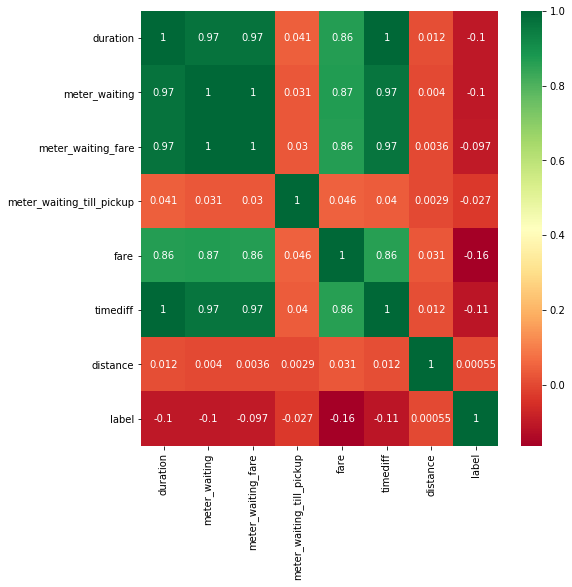

In [147]:
import seaborn as sns
train_df = pd.read_csv(
    DATA_PATH / "train.csv", 
    index_col="tripid"
)
train_df['label'] = train_df['label'].map({"correct":1, "incorrect":0})
train_df_cols = train_df.columns.values
li = list(train_df_cols)
features_df = train_df[li[0:-1]]
labels_df = train_df[li[-1]]
features_df = formatdata(features_df)
features_df = features_df.join(labels_df)

labels_df.fillna(0)
features_df[features_df==np.inf]=np.nan
features_df.fillna(0, inplace=True)
numericOnle = ['duration','meter_waiting','meter_waiting_fare','meter_waiting_till_pickup','fare','timediff','distance','label']
features_set = features_df[numericOnle]

#get correlations of each features in dataset
corrmat = features_set.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(8,8))
#plot heat map
g=sns.heatmap(features_set[top_corr_features].corr(),annot=True,cmap="RdYlGn")